*Ставим новую версию библиотеки для импорта датасета*

In [1]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-kly9u8qb
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7ujc8dw/wheels/04/6d/bf/cc14a58bae32d07d1c7d23833dc5ea655e477ff25061b8cd57
Successfully built torchvision
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torchvision 0.2.2.post3
    Uninstalling torchvision-0.2.2.post3:
      Successfully uninstalled torchvision-0.2.2.post3


In [0]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [4]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.CelebA('data', download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

1443490838it [00:09, 157641940.31it/s]
26721026it [00:01, 20299156.03it/s]
3424458it [00:00, 97733564.82it/s]
6082035it [00:00, 19748619.28it/s]
12156055it [00:00, 37680046.79it/s]
2836386it [00:00, 121480074.19it/s]


In [0]:
def show_image(img):
    img=(img.cpu().data.numpy().transpose(1, 2, 0)+1)/2
    plt.imshow(img)
    plt.show()

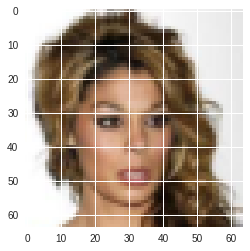

In [6]:
show_image(dataset[5][0])

Генератор будет учится создавать изображения, похожие на людей

In [0]:
num_channels = 3
latent_size = 100
base_size = image_size

G = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d(latent_size, base_size * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.ReLU(True),
    
    # (base_size*8) x 4 x 4
    nn.ConvTranspose2d(base_size * 8, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.ReLU(True),
    
    # (base_size*4) x 8 x 8
    nn.ConvTranspose2d(base_size * 4, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.ReLU(True),
    
    # (base_size*2) x 16 x 16
    nn.ConvTranspose2d(base_size * 2, base_size, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.ReLU(True),
    
    # (base_size) x 32 x 32
    nn.ConvTranspose2d(base_size, num_channels, 4, 2, 1, bias=False),
    nn.Tanh()
    # (num_channels) x 64 x 64
).to(device)

In [8]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z).shape

torch.Size([1, 3, 64, 64])

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d...

In [0]:
D = nn.Sequential(

    nn.Conv2d(num_channels, base_size , 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(base_size, base_size * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 2),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*2) x 16 x 16
    nn.Conv2d(base_size * 2, base_size * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*4) x 8 x 8
    nn.Conv2d(base_size * 4, base_size * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(base_size * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # state size. (ndf*8) x 4 x 4
    nn.Conv2d(base_size * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid()
).to(device)


In [10]:
z = torch.randn(64, latent_size, 1, 1).to(device)
D(G(z.to(device))).shape

torch.Size([64, 1, 1, 1])

In [11]:
for i,_ in loader:
  print(D(i.to(device)).shape)
  break

torch.Size([64, 1, 1, 1])


В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

In [13]:
G.apply(weights_init)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

0/10, 0.0%
  G loss: 2.4468910694122314
  D loss: 1.0757371187210083


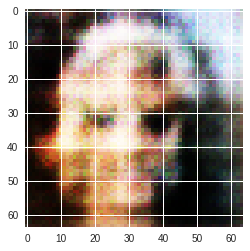

0/10, 1.9654088050314464%
  G loss: 1.8762249946594238
  D loss: 1.0921869277954102
0/10, 3.930817610062893%
  G loss: 2.237435817718506
  D loss: 0.8970768451690674
0/10, 5.89622641509434%
  G loss: 2.6455678939819336
  D loss: 0.8136047124862671
0/10, 7.861635220125786%
  G loss: 3.170135498046875
  D loss: 1.0638854503631592


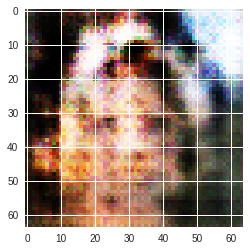

0/10, 9.827044025157234%
  G loss: 3.0863161087036133
  D loss: 0.9429197311401367
0/10, 11.79245283018868%
  G loss: 3.738879442214966
  D loss: 1.2069578170776367
0/10, 13.757861635220126%
  G loss: 3.342165470123291
  D loss: 1.0745981931686401
0/10, 15.723270440251572%
  G loss: 3.27103328704834
  D loss: 0.8228565454483032


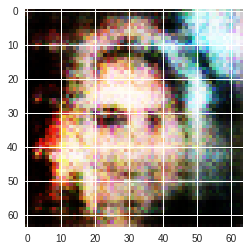

0/10, 17.68867924528302%
  G loss: 3.016011953353882
  D loss: 0.8517006635665894
0/10, 19.654088050314467%
  G loss: 3.104210138320923
  D loss: 0.8388376832008362
0/10, 21.61949685534591%
  G loss: 3.327965497970581
  D loss: 0.8774197697639465
0/10, 23.58490566037736%
  G loss: 2.8710782527923584
  D loss: 0.7086489200592041


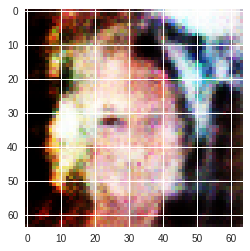

0/10, 25.550314465408807%
  G loss: 2.8691623210906982
  D loss: 0.7268601655960083
0/10, 27.51572327044025%
  G loss: 3.056459665298462
  D loss: 0.5401744842529297
0/10, 29.4811320754717%
  G loss: 3.7958083152770996
  D loss: 0.5417001843452454
0/10, 31.446540880503143%
  G loss: 3.7548294067382812
  D loss: 0.7127667665481567


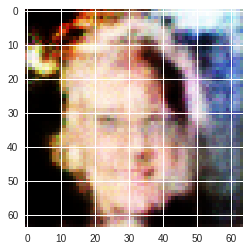

0/10, 33.411949685534594%
  G loss: 3.573051929473877
  D loss: 0.5154992938041687
0/10, 35.37735849056604%
  G loss: 3.0171196460723877
  D loss: 0.5803963541984558
0/10, 37.34276729559748%
  G loss: 2.826150894165039
  D loss: 0.577402651309967
0/10, 39.308176100628934%
  G loss: 4.9537553787231445
  D loss: 0.6510819792747498


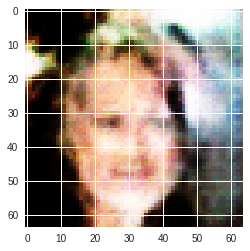

0/10, 41.27358490566038%
  G loss: 4.2906012535095215
  D loss: 0.5867018699645996
0/10, 43.23899371069182%
  G loss: 3.0313198566436768
  D loss: 0.4089381694793701
0/10, 45.20440251572327%
  G loss: 4.11262321472168
  D loss: 0.4479628801345825
0/10, 47.16981132075472%
  G loss: 4.372136116027832
  D loss: 0.7004435062408447


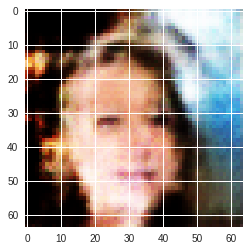

0/10, 49.13522012578616%
  G loss: 4.570731163024902
  D loss: 0.4889053702354431
0/10, 51.100628930817614%
  G loss: 2.6727421283721924
  D loss: 0.5300965905189514
0/10, 53.06603773584906%
  G loss: 3.2238004207611084
  D loss: 0.40130406618118286
0/10, 55.0314465408805%
  G loss: 1.9346287250518799
  D loss: 0.8512888550758362


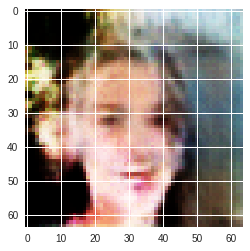

0/10, 56.996855345911946%
  G loss: 4.4937849044799805
  D loss: 0.5491754412651062
0/10, 58.9622641509434%
  G loss: 3.2656443119049072
  D loss: 0.39236897230148315
0/10, 60.92767295597484%
  G loss: 3.4701168537139893
  D loss: 0.6138138175010681
0/10, 62.893081761006286%
  G loss: 3.7004005908966064
  D loss: 0.5465110540390015


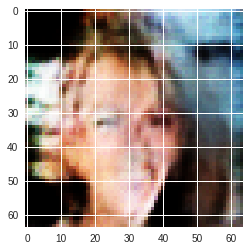

0/10, 64.85849056603774%
  G loss: 3.041451930999756
  D loss: 0.3655574917793274
0/10, 66.82389937106919%
  G loss: 1.4098689556121826
  D loss: 0.7026880383491516
0/10, 68.78930817610063%
  G loss: 4.386020183563232
  D loss: 0.6961601972579956
0/10, 70.75471698113208%
  G loss: 3.2157249450683594
  D loss: 0.5810429453849792


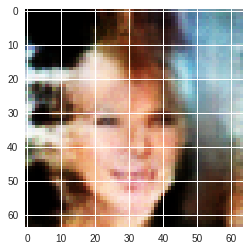

0/10, 72.72012578616352%
  G loss: 4.950519561767578
  D loss: 0.8485687375068665
0/10, 74.68553459119497%
  G loss: 1.9276472330093384
  D loss: 0.5684957504272461
0/10, 76.65094339622641%
  G loss: 1.4496815204620361
  D loss: 0.6924439072608948
0/10, 78.61635220125787%
  G loss: 2.206240177154541
  D loss: 0.5940535068511963


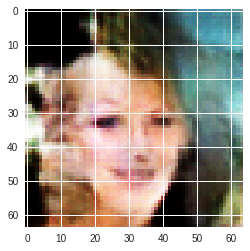

0/10, 80.58176100628931%
  G loss: 2.7704710960388184
  D loss: 0.5892128348350525
0/10, 82.54716981132076%
  G loss: 3.1589369773864746
  D loss: 0.5030946135520935
0/10, 84.5125786163522%
  G loss: 3.471662998199463
  D loss: 0.5166335701942444
0/10, 86.47798742138365%
  G loss: 5.77080774307251
  D loss: 1.5042942762374878


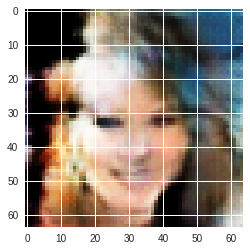

0/10, 88.44339622641509%
  G loss: 2.27297306060791
  D loss: 0.47183284163475037
0/10, 90.40880503144653%
  G loss: 4.617122173309326
  D loss: 0.9725056886672974
0/10, 92.37421383647799%
  G loss: 2.1069135665893555
  D loss: 0.6870260238647461
0/10, 94.33962264150944%
  G loss: 1.6201519966125488
  D loss: 0.9632881879806519


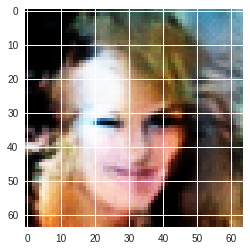

0/10, 96.30503144654088%
  G loss: 1.5946755409240723
  D loss: 0.6797693967819214
0/10, 98.27044025157232%
  G loss: 1.9179210662841797
  D loss: 0.6881864070892334
1/10, 0.0%
  G loss: 2.2856528759002686
  D loss: 0.5842908620834351


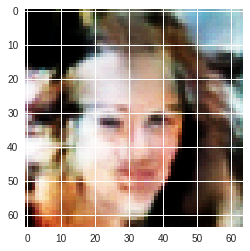

1/10, 1.9654088050314464%
  G loss: 4.250317573547363
  D loss: 0.4781157970428467
1/10, 3.930817610062893%
  G loss: 2.457998752593994
  D loss: 0.48474591970443726
1/10, 5.89622641509434%
  G loss: 3.54616379737854
  D loss: 0.4529985189437866
1/10, 7.861635220125786%
  G loss: 1.3723416328430176
  D loss: 0.8281721472740173


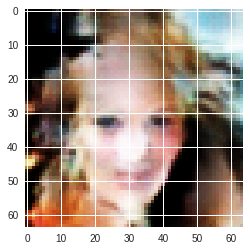

1/10, 9.827044025157234%
  G loss: 1.3983509540557861
  D loss: 0.6364386081695557
1/10, 11.79245283018868%
  G loss: 2.509697437286377
  D loss: 0.49373358488082886
1/10, 13.757861635220126%
  G loss: 3.368007183074951
  D loss: 0.5791558623313904
1/10, 15.723270440251572%
  G loss: 2.3020174503326416
  D loss: 0.5145053863525391


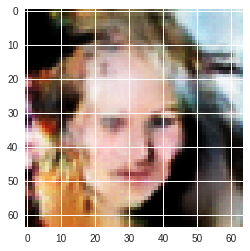

1/10, 17.68867924528302%
  G loss: 2.390768527984619
  D loss: 0.5010015964508057
1/10, 19.654088050314467%
  G loss: 5.9357523918151855
  D loss: 1.339921474456787
1/10, 21.61949685534591%
  G loss: 3.458078384399414
  D loss: 0.5121946334838867
1/10, 23.58490566037736%
  G loss: 3.641889810562134
  D loss: 0.532757043838501


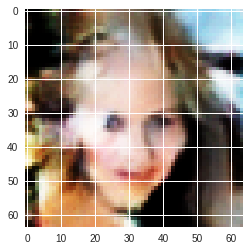

1/10, 25.550314465408807%
  G loss: 3.5741562843322754
  D loss: 0.4700157046318054
1/10, 27.51572327044025%
  G loss: 2.7995166778564453
  D loss: 0.45704445242881775
1/10, 29.4811320754717%
  G loss: 1.9362776279449463
  D loss: 0.45409587025642395
1/10, 31.446540880503143%
  G loss: 2.5623536109924316
  D loss: 0.6461460590362549


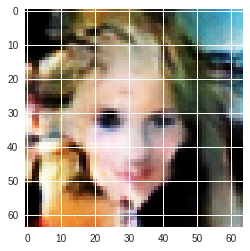

1/10, 33.411949685534594%
  G loss: 1.8738374710083008
  D loss: 1.3607491254806519
1/10, 35.37735849056604%
  G loss: 2.223123073577881
  D loss: 0.5877227783203125
1/10, 37.34276729559748%
  G loss: 3.231304883956909
  D loss: 0.8029375672340393
1/10, 39.308176100628934%
  G loss: 2.828897714614868
  D loss: 0.5480408668518066


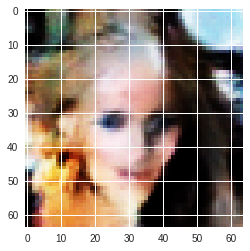

1/10, 41.27358490566038%
  G loss: 2.4589927196502686
  D loss: 0.4751598834991455
1/10, 43.23899371069182%
  G loss: 2.4706764221191406
  D loss: 0.6360486745834351
1/10, 45.20440251572327%
  G loss: 3.437832832336426
  D loss: 0.374395489692688
1/10, 47.16981132075472%
  G loss: 1.9510475397109985
  D loss: 0.5615072846412659


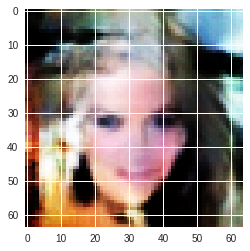

1/10, 49.13522012578616%
  G loss: 1.6564531326293945
  D loss: 0.7342848777770996
1/10, 51.100628930817614%
  G loss: 1.753467082977295
  D loss: 0.8280922174453735
1/10, 53.06603773584906%
  G loss: 5.055957794189453
  D loss: 0.7225244045257568
1/10, 55.0314465408805%
  G loss: 0.8786507248878479
  D loss: 0.7193536758422852


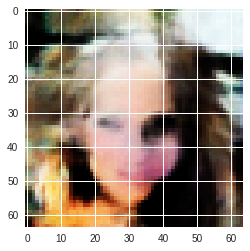

1/10, 56.996855345911946%
  G loss: 4.365365982055664
  D loss: 0.737648606300354
1/10, 58.9622641509434%
  G loss: 2.0789995193481445
  D loss: 0.49420881271362305
1/10, 60.92767295597484%
  G loss: 2.6891539096832275
  D loss: 0.5822356939315796
1/10, 62.893081761006286%
  G loss: 3.3908443450927734
  D loss: 0.34849444031715393


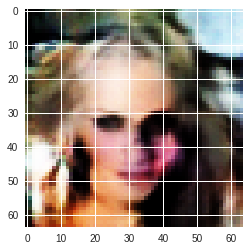

1/10, 64.85849056603774%
  G loss: 2.712259292602539
  D loss: 0.47491708397865295
1/10, 66.82389937106919%
  G loss: 2.485255718231201
  D loss: 0.637578010559082
1/10, 68.78930817610063%
  G loss: 2.130211353302002
  D loss: 0.5782532691955566
1/10, 70.75471698113208%
  G loss: 3.94065260887146
  D loss: 0.4943038821220398


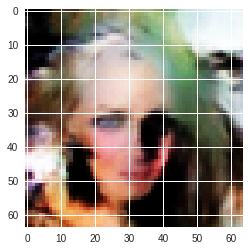

1/10, 72.72012578616352%
  G loss: 1.7059597969055176
  D loss: 0.6206693649291992
1/10, 74.68553459119497%
  G loss: 3.3677921295166016
  D loss: 0.5162267088890076
1/10, 76.65094339622641%
  G loss: 1.0184428691864014
  D loss: 0.9183350205421448
1/10, 78.61635220125787%
  G loss: 2.499925136566162
  D loss: 0.48954206705093384


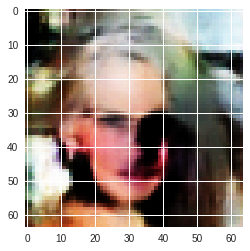

1/10, 80.58176100628931%
  G loss: 3.9193994998931885
  D loss: 0.7595378160476685
1/10, 82.54716981132076%
  G loss: 1.9187796115875244
  D loss: 0.6323714256286621
1/10, 84.5125786163522%
  G loss: 4.249110221862793
  D loss: 1.0438580513000488
1/10, 86.47798742138365%
  G loss: 1.5968652963638306
  D loss: 0.9101686477661133


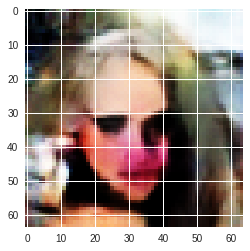

1/10, 88.44339622641509%
  G loss: 2.409644365310669
  D loss: 0.4169568717479706
1/10, 90.40880503144653%
  G loss: 2.9475045204162598
  D loss: 0.3824352025985718
1/10, 92.37421383647799%
  G loss: 0.30688512325286865
  D loss: 1.717944860458374
1/10, 94.33962264150944%
  G loss: 1.7327008247375488
  D loss: 0.6295625567436218


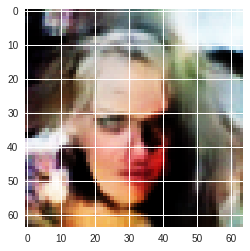

1/10, 96.30503144654088%
  G loss: 1.7850316762924194
  D loss: 0.6239038705825806
1/10, 98.27044025157232%
  G loss: 2.8163490295410156
  D loss: 0.4861848056316376
2/10, 0.0%
  G loss: 1.734347939491272
  D loss: 0.7317104339599609


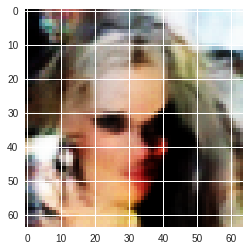

2/10, 1.9654088050314464%
  G loss: 3.577052116394043
  D loss: 0.5148337483406067
2/10, 3.930817610062893%
  G loss: 2.519246816635132
  D loss: 0.6258307695388794
2/10, 5.89622641509434%
  G loss: 5.706653594970703
  D loss: 0.888691782951355
2/10, 7.861635220125786%
  G loss: 3.1926398277282715
  D loss: 0.6531424522399902


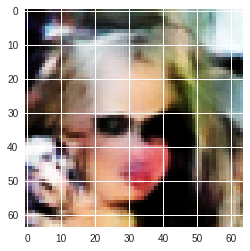

2/10, 9.827044025157234%
  G loss: 2.9925434589385986
  D loss: 0.5157427787780762
2/10, 11.79245283018868%
  G loss: 2.5518622398376465
  D loss: 0.8033955693244934
2/10, 13.757861635220126%
  G loss: 3.2640490531921387
  D loss: 0.6514856219291687
2/10, 15.723270440251572%
  G loss: 3.3407793045043945
  D loss: 0.6431623101234436


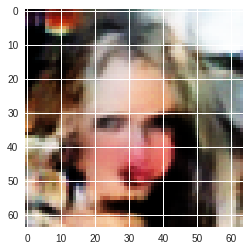

2/10, 17.68867924528302%
  G loss: 1.3131012916564941
  D loss: 0.6434197425842285
2/10, 19.654088050314467%
  G loss: 2.2524056434631348
  D loss: 0.5516097545623779
2/10, 21.61949685534591%
  G loss: 2.288825511932373
  D loss: 0.4565296173095703
2/10, 23.58490566037736%
  G loss: 4.560111045837402
  D loss: 0.7071277499198914


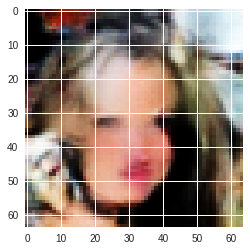

2/10, 25.550314465408807%
  G loss: 3.334278106689453
  D loss: 0.358198881149292
2/10, 27.51572327044025%
  G loss: 2.0843043327331543
  D loss: 0.4928811192512512
2/10, 29.4811320754717%
  G loss: 6.008016586303711
  D loss: 3.1264421939849854
2/10, 31.446540880503143%
  G loss: 1.3533021211624146
  D loss: 0.9897491931915283


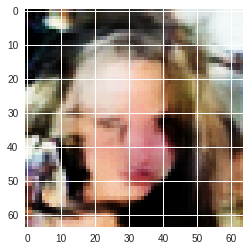

2/10, 33.411949685534594%
  G loss: 2.1874094009399414
  D loss: 0.5363764762878418
2/10, 35.37735849056604%
  G loss: 0.7744535207748413
  D loss: 0.8602573871612549
2/10, 37.34276729559748%
  G loss: 2.3810696601867676
  D loss: 0.5039676427841187
2/10, 39.308176100628934%
  G loss: 2.2686080932617188
  D loss: 0.4027353525161743


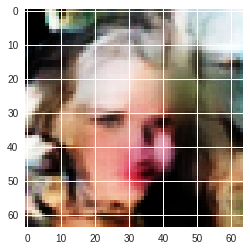

2/10, 41.27358490566038%
  G loss: 2.3238186836242676
  D loss: 0.4253652095794678
2/10, 43.23899371069182%
  G loss: 2.1993932723999023
  D loss: 0.6352366209030151
2/10, 45.20440251572327%
  G loss: 4.452459812164307
  D loss: 0.9146252274513245
2/10, 47.16981132075472%
  G loss: 2.72021222114563
  D loss: 0.5031957626342773


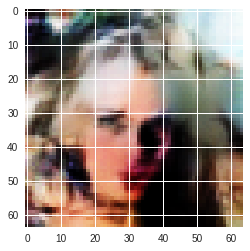

2/10, 49.13522012578616%
  G loss: 4.720996856689453
  D loss: 0.563098132610321
2/10, 51.100628930817614%
  G loss: 2.615973711013794
  D loss: 0.6885911226272583
2/10, 53.06603773584906%
  G loss: 3.574542760848999
  D loss: 0.6695679426193237
2/10, 55.0314465408805%
  G loss: 2.3563618659973145
  D loss: 0.504610002040863


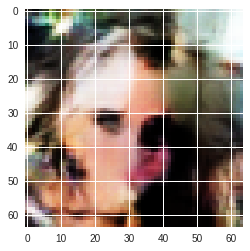

2/10, 56.996855345911946%
  G loss: 2.2848501205444336
  D loss: 0.5427898168563843
2/10, 58.9622641509434%
  G loss: 3.2540392875671387
  D loss: 0.5269765257835388
2/10, 60.92767295597484%
  G loss: 3.3213891983032227
  D loss: 0.4643707871437073
2/10, 62.893081761006286%
  G loss: 3.316396474838257
  D loss: 0.36070168018341064


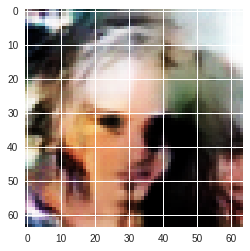

2/10, 64.85849056603774%
  G loss: 3.192831516265869
  D loss: 0.4253770411014557
2/10, 66.82389937106919%
  G loss: 3.2953827381134033
  D loss: 0.5023735165596008
2/10, 68.78930817610063%
  G loss: 1.9660332202911377
  D loss: 0.578916609287262
2/10, 70.75471698113208%
  G loss: 3.073854923248291
  D loss: 0.5201860070228577


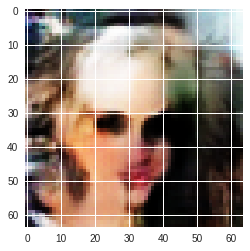

2/10, 72.72012578616352%
  G loss: 3.2496755123138428
  D loss: 0.37247422337532043
2/10, 74.68553459119497%
  G loss: 2.2443184852600098
  D loss: 0.4526035189628601
2/10, 76.65094339622641%
  G loss: 1.707653284072876
  D loss: 1.5772079229354858
2/10, 78.61635220125787%
  G loss: 2.724205255508423
  D loss: 0.45989692211151123


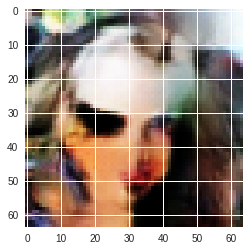

2/10, 80.58176100628931%
  G loss: 3.1534171104431152
  D loss: 0.5794937610626221
2/10, 82.54716981132076%
  G loss: 2.635103225708008
  D loss: 0.2826024293899536
2/10, 84.5125786163522%
  G loss: 3.702263355255127
  D loss: 0.3707497715950012
2/10, 86.47798742138365%
  G loss: 3.3843789100646973
  D loss: 0.45765623450279236


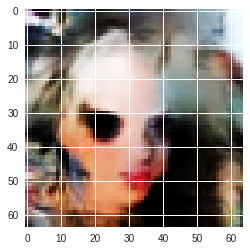

2/10, 88.44339622641509%
  G loss: 2.379225730895996
  D loss: 0.5362530946731567
2/10, 90.40880503144653%
  G loss: 3.653745174407959
  D loss: 0.5266302227973938
2/10, 92.37421383647799%
  G loss: 4.276459693908691
  D loss: 0.5200563669204712
2/10, 94.33962264150944%
  G loss: 2.2218103408813477
  D loss: 0.42992910742759705


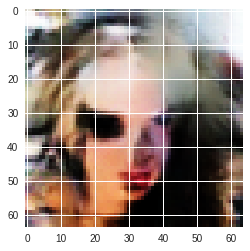

2/10, 96.30503144654088%
  G loss: 4.949743270874023
  D loss: 1.210000991821289
2/10, 98.27044025157232%
  G loss: 2.621532678604126
  D loss: 0.46342143416404724
3/10, 0.0%
  G loss: 2.863607883453369
  D loss: 0.3536624014377594


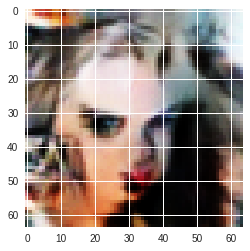

3/10, 1.9654088050314464%
  G loss: 3.26043701171875
  D loss: 0.2952631115913391
3/10, 3.930817610062893%
  G loss: 2.8268189430236816
  D loss: 0.4730902314186096
3/10, 5.89622641509434%
  G loss: 2.1387362480163574
  D loss: 0.5928252339363098
3/10, 7.861635220125786%
  G loss: 1.9992241859436035
  D loss: 0.5152600407600403


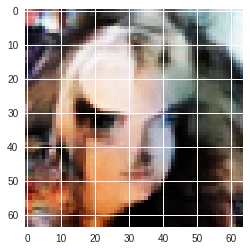

3/10, 9.827044025157234%
  G loss: 2.744213104248047
  D loss: 0.4393590986728668
3/10, 11.79245283018868%
  G loss: 3.3695602416992188
  D loss: 0.36894601583480835
3/10, 13.757861635220126%
  G loss: 2.507586717605591
  D loss: 0.45176905393600464
3/10, 15.723270440251572%
  G loss: 1.3640071153640747
  D loss: 0.8177395462989807


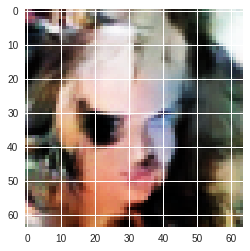

3/10, 17.68867924528302%
  G loss: 0.7110435366630554
  D loss: 1.3533419370651245
3/10, 19.654088050314467%
  G loss: 1.696660041809082
  D loss: 0.6812086701393127
3/10, 21.61949685534591%
  G loss: 2.560978651046753
  D loss: 0.3945167064666748
3/10, 23.58490566037736%
  G loss: 2.000826358795166
  D loss: 0.5835380554199219


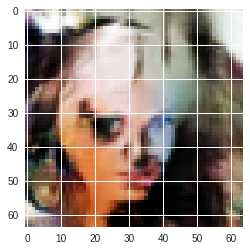

3/10, 25.550314465408807%
  G loss: 6.0102386474609375
  D loss: 1.4257022142410278
3/10, 27.51572327044025%
  G loss: 2.680067300796509
  D loss: 0.4829558730125427
3/10, 29.4811320754717%
  G loss: 1.8471895456314087
  D loss: 0.519853413105011
3/10, 31.446540880503143%
  G loss: 6.769933700561523
  D loss: 1.852536678314209


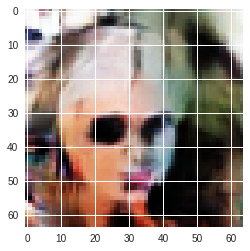

3/10, 33.411949685534594%
  G loss: 4.028716564178467
  D loss: 0.5674372315406799
3/10, 35.37735849056604%
  G loss: 1.9826254844665527
  D loss: 0.6627206802368164
3/10, 37.34276729559748%
  G loss: 3.2194130420684814
  D loss: 0.4617902636528015
3/10, 39.308176100628934%
  G loss: 1.5187897682189941
  D loss: 0.5626318454742432


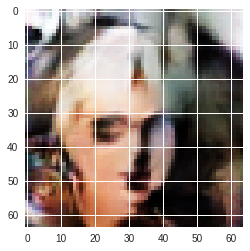

3/10, 41.27358490566038%
  G loss: 5.345491886138916
  D loss: 1.0662301778793335
3/10, 43.23899371069182%
  G loss: 2.5546860694885254
  D loss: 0.39777708053588867
3/10, 45.20440251572327%
  G loss: 2.57932186126709
  D loss: 0.5610641241073608
3/10, 47.16981132075472%
  G loss: 2.3312735557556152
  D loss: 0.3964797854423523


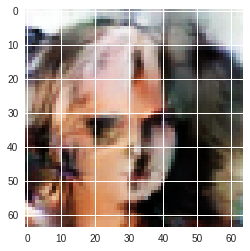

3/10, 49.13522012578616%
  G loss: 2.43001651763916
  D loss: 0.5058728456497192
3/10, 51.100628930817614%
  G loss: 2.2158398628234863
  D loss: 0.4903048574924469
3/10, 53.06603773584906%
  G loss: 4.232722759246826
  D loss: 0.6073701977729797
3/10, 55.0314465408805%
  G loss: 3.4397034645080566
  D loss: 0.45404839515686035


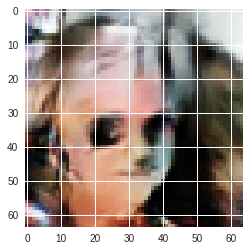

3/10, 56.996855345911946%
  G loss: 4.333209991455078
  D loss: 0.3203922212123871
3/10, 58.9622641509434%
  G loss: 1.6597989797592163
  D loss: 0.5578715205192566
3/10, 60.92767295597484%
  G loss: 2.6588010787963867
  D loss: 0.5321289300918579
3/10, 62.893081761006286%
  G loss: 1.8284536600112915
  D loss: 0.5154277682304382


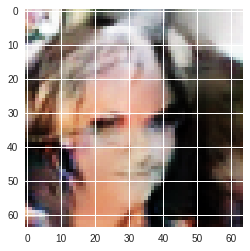

3/10, 64.85849056603774%
  G loss: 1.707306146621704
  D loss: 0.7802018523216248
3/10, 66.82389937106919%
  G loss: 2.838697910308838
  D loss: 0.38708335161209106
3/10, 68.78930817610063%
  G loss: 3.2853550910949707
  D loss: 0.43602657318115234
3/10, 70.75471698113208%
  G loss: 1.6360570192337036
  D loss: 0.37525051832199097


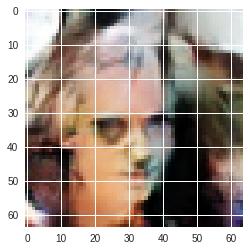

3/10, 72.72012578616352%
  G loss: 2.883633852005005
  D loss: 0.4899839758872986
3/10, 74.68553459119497%
  G loss: 1.029287576675415
  D loss: 0.5609031915664673
3/10, 76.65094339622641%
  G loss: 4.248579978942871
  D loss: 0.3099677562713623
3/10, 78.61635220125787%
  G loss: 3.1609113216400146
  D loss: 0.34964269399642944


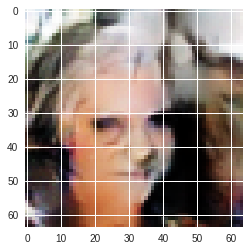

3/10, 80.58176100628931%
  G loss: 5.419371604919434
  D loss: 1.0791717767715454
3/10, 82.54716981132076%
  G loss: 1.0954210758209229
  D loss: 1.2270992994308472
3/10, 84.5125786163522%
  G loss: 1.4212658405303955
  D loss: 0.5407809615135193
3/10, 86.47798742138365%
  G loss: 2.6462979316711426
  D loss: 0.4364040493965149


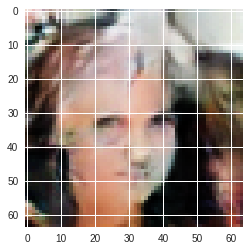

3/10, 88.44339622641509%
  G loss: 2.746812343597412
  D loss: 0.33422237634658813
3/10, 90.40880503144653%
  G loss: 5.045361042022705
  D loss: 0.7737318873405457
3/10, 92.37421383647799%
  G loss: 3.971447706222534
  D loss: 0.7670248746871948
3/10, 94.33962264150944%
  G loss: 3.8040289878845215
  D loss: 0.6662977933883667


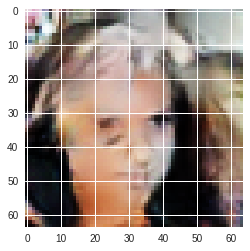

3/10, 96.30503144654088%
  G loss: 2.4870121479034424
  D loss: 0.478860080242157
3/10, 98.27044025157232%
  G loss: 4.760746002197266
  D loss: 0.4152195453643799
4/10, 0.0%
  G loss: 5.664053440093994
  D loss: 0.7490975856781006


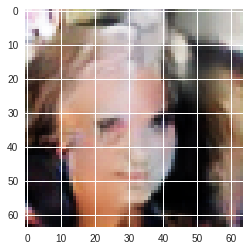

4/10, 1.9654088050314464%
  G loss: 4.321885585784912
  D loss: 0.23163816332817078
4/10, 3.930817610062893%
  G loss: 5.235630035400391
  D loss: 0.7373654246330261
4/10, 5.89622641509434%
  G loss: 2.2983510494232178
  D loss: 0.6507518887519836
4/10, 7.861635220125786%
  G loss: 3.6564860343933105
  D loss: 0.3138943910598755


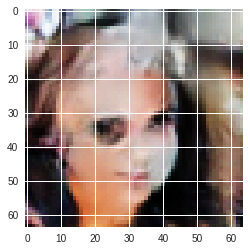

4/10, 9.827044025157234%
  G loss: 0.6626265048980713
  D loss: 3.437492609024048
4/10, 11.79245283018868%
  G loss: 2.405531883239746
  D loss: 0.3159988224506378
4/10, 13.757861635220126%
  G loss: 2.9535281658172607
  D loss: 0.2598561644554138
4/10, 15.723270440251572%
  G loss: 3.165131092071533
  D loss: 0.37514615058898926


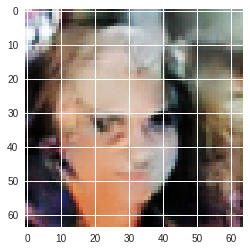

4/10, 17.68867924528302%
  G loss: 3.443800449371338
  D loss: 0.2297683209180832
4/10, 19.654088050314467%
  G loss: 1.746936321258545
  D loss: 0.6202070713043213
4/10, 21.61949685534591%
  G loss: 3.7022578716278076
  D loss: 0.4165852963924408
4/10, 23.58490566037736%
  G loss: 2.764965772628784
  D loss: 0.31795960664749146


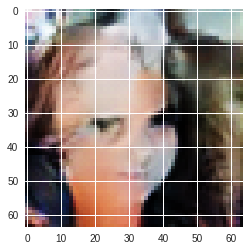

4/10, 25.550314465408807%
  G loss: 3.702115058898926
  D loss: 0.3520963191986084
4/10, 27.51572327044025%
  G loss: 1.188145399093628
  D loss: 1.2518947124481201
4/10, 29.4811320754717%
  G loss: 4.820638179779053
  D loss: 0.24380886554718018
4/10, 31.446540880503143%
  G loss: 2.3982443809509277
  D loss: 0.4513114392757416


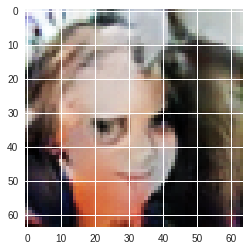

4/10, 33.411949685534594%
  G loss: 4.160007953643799
  D loss: 0.47352564334869385
4/10, 35.37735849056604%
  G loss: 3.579359292984009
  D loss: 0.3139271140098572
4/10, 37.34276729559748%
  G loss: 4.079248428344727
  D loss: 0.3595934510231018
4/10, 39.308176100628934%
  G loss: 5.255190372467041
  D loss: 1.5034573078155518


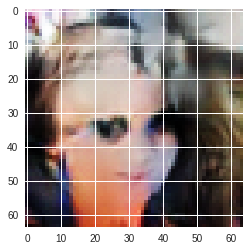

4/10, 41.27358490566038%
  G loss: 2.2489986419677734
  D loss: 0.5265295505523682
4/10, 43.23899371069182%
  G loss: 2.648665428161621
  D loss: 0.37783950567245483
4/10, 45.20440251572327%
  G loss: 3.3019442558288574
  D loss: 0.2850900888442993
4/10, 47.16981132075472%
  G loss: 3.4868717193603516
  D loss: 0.3117058277130127


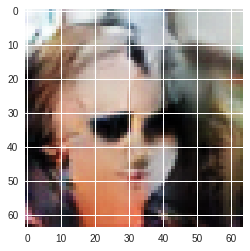

4/10, 49.13522012578616%
  G loss: 5.296987056732178
  D loss: 0.6246321797370911
4/10, 51.100628930817614%
  G loss: 2.1752705574035645
  D loss: 0.4749618172645569
4/10, 53.06603773584906%
  G loss: 2.4718589782714844
  D loss: 0.3681567907333374
4/10, 55.0314465408805%
  G loss: 2.693830966949463
  D loss: 0.3756147623062134


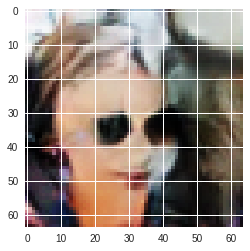

4/10, 56.996855345911946%
  G loss: 3.3854079246520996
  D loss: 0.31093519926071167
4/10, 58.9622641509434%
  G loss: 3.506399631500244
  D loss: 0.5160394310951233
4/10, 60.92767295597484%
  G loss: 4.365379333496094
  D loss: 0.5489179491996765
4/10, 62.893081761006286%
  G loss: 3.9616074562072754
  D loss: 0.44354796409606934


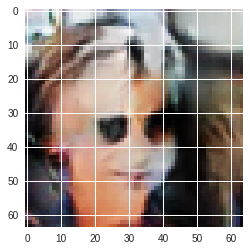

4/10, 64.85849056603774%
  G loss: 3.0708603858947754
  D loss: 0.3358912467956543
4/10, 66.82389937106919%
  G loss: 2.4865000247955322
  D loss: 0.39633479714393616
4/10, 68.78930817610063%
  G loss: 3.2687056064605713
  D loss: 0.7824082374572754
4/10, 70.75471698113208%
  G loss: 3.22265625
  D loss: 0.3032967448234558


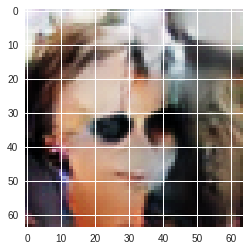

4/10, 72.72012578616352%
  G loss: 0.06749214231967926
  D loss: 1.474270224571228
4/10, 74.68553459119497%
  G loss: 2.5080463886260986
  D loss: 0.32866406440734863
4/10, 76.65094339622641%
  G loss: 2.7048230171203613
  D loss: 0.4683864414691925
4/10, 78.61635220125787%
  G loss: 3.248608112335205
  D loss: 0.24514445662498474


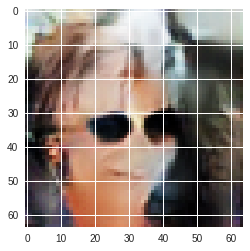

4/10, 80.58176100628931%
  G loss: 3.1508290767669678
  D loss: 0.24601006507873535
4/10, 82.54716981132076%
  G loss: 2.927077293395996
  D loss: 0.3204606771469116
4/10, 84.5125786163522%
  G loss: 4.884402275085449
  D loss: 0.4519280791282654
4/10, 86.47798742138365%
  G loss: 2.173201560974121
  D loss: 0.4923766553401947


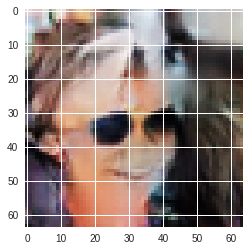

4/10, 88.44339622641509%
  G loss: 3.9500017166137695
  D loss: 0.2387017011642456
4/10, 90.40880503144653%
  G loss: 3.734206199645996
  D loss: 0.49296262860298157
4/10, 92.37421383647799%
  G loss: 0.8024946451187134
  D loss: 1.2732809782028198
4/10, 94.33962264150944%
  G loss: 3.081371784210205
  D loss: 0.23348800837993622


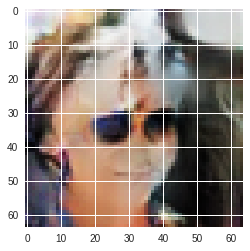

4/10, 96.30503144654088%
  G loss: 4.484856605529785
  D loss: 0.5453414916992188
4/10, 98.27044025157232%
  G loss: 4.235614776611328
  D loss: 0.5024062395095825
5/10, 0.0%
  G loss: 3.9422106742858887
  D loss: 0.3769374489784241


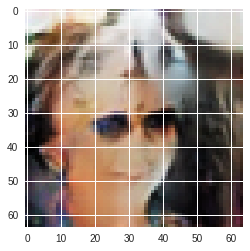

5/10, 1.9654088050314464%
  G loss: 1.7488760948181152
  D loss: 0.4477621018886566
5/10, 3.930817610062893%
  G loss: 1.9287792444229126
  D loss: 0.4346567988395691
5/10, 5.89622641509434%
  G loss: 3.537839412689209
  D loss: 0.31913089752197266
5/10, 7.861635220125786%
  G loss: 3.312915325164795
  D loss: 0.3589896559715271


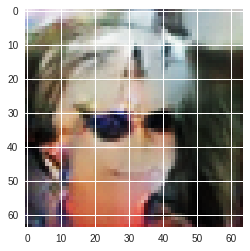

5/10, 9.827044025157234%
  G loss: 2.2506351470947266
  D loss: 0.37559160590171814
5/10, 11.79245283018868%
  G loss: 5.866685390472412
  D loss: 0.6733924150466919
5/10, 13.757861635220126%
  G loss: 3.7871599197387695
  D loss: 0.37516140937805176
5/10, 15.723270440251572%
  G loss: 4.731128692626953
  D loss: 0.43749552965164185


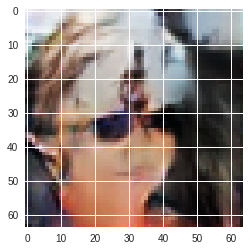

5/10, 17.68867924528302%
  G loss: 4.635883331298828
  D loss: 0.38136112689971924
5/10, 19.654088050314467%
  G loss: 4.253859519958496
  D loss: 0.40308743715286255
5/10, 21.61949685534591%
  G loss: 4.090122222900391
  D loss: 0.47302064299583435
5/10, 23.58490566037736%
  G loss: 3.76365065574646
  D loss: 0.2710989713668823


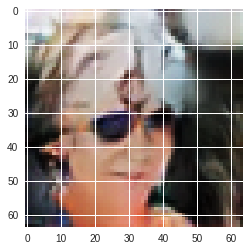

5/10, 25.550314465408807%
  G loss: 3.045168876647949
  D loss: 0.43096834421157837
5/10, 27.51572327044025%
  G loss: 2.241161346435547
  D loss: 0.36613166332244873
5/10, 29.4811320754717%
  G loss: 5.131800651550293
  D loss: 0.6268486380577087
5/10, 31.446540880503143%
  G loss: 2.590487480163574
  D loss: 0.6696422100067139


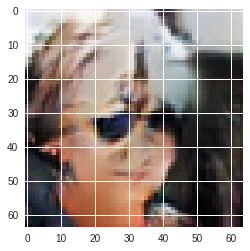

5/10, 33.411949685534594%
  G loss: 5.757150650024414
  D loss: 0.7018336057662964
5/10, 35.37735849056604%
  G loss: 2.3736908435821533
  D loss: 0.39648303389549255
5/10, 37.34276729559748%
  G loss: 3.80177640914917
  D loss: 0.18497028946876526
5/10, 39.308176100628934%
  G loss: 2.3837695121765137
  D loss: 0.3607942461967468


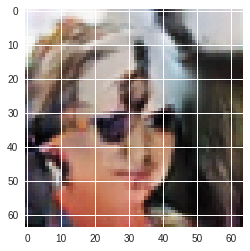

5/10, 41.27358490566038%
  G loss: 2.531529426574707
  D loss: 0.4178333580493927
5/10, 43.23899371069182%
  G loss: 2.0491228103637695
  D loss: 0.3445523679256439
5/10, 45.20440251572327%
  G loss: 4.13855504989624
  D loss: 1.0234291553497314
5/10, 47.16981132075472%
  G loss: 2.6707866191864014
  D loss: 0.38579073548316956


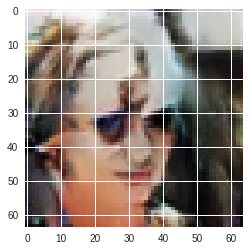

5/10, 49.13522012578616%
  G loss: 1.8436360359191895
  D loss: 0.4611111581325531
5/10, 51.100628930817614%
  G loss: 3.327012062072754
  D loss: 0.2260650098323822
5/10, 53.06603773584906%
  G loss: 4.63369083404541
  D loss: 0.5104089379310608
5/10, 55.0314465408805%
  G loss: 2.912937641143799
  D loss: 0.4941008985042572


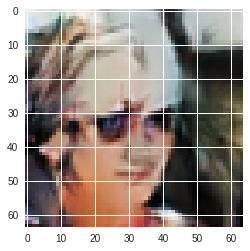

5/10, 56.996855345911946%
  G loss: 3.876236915588379
  D loss: 0.5121636986732483
5/10, 58.9622641509434%
  G loss: 2.4679722785949707
  D loss: 0.42782554030418396
5/10, 60.92767295597484%
  G loss: 3.5101072788238525
  D loss: 0.21004977822303772
5/10, 62.893081761006286%
  G loss: 3.777622699737549
  D loss: 0.1722370684146881


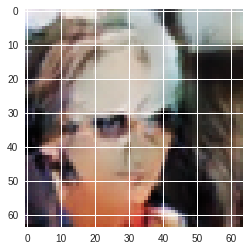

5/10, 64.85849056603774%
  G loss: 1.0783642530441284
  D loss: 0.7543558478355408
5/10, 66.82389937106919%
  G loss: 2.6133596897125244
  D loss: 0.3047153353691101
5/10, 68.78930817610063%
  G loss: 4.955770969390869
  D loss: 0.5340328812599182
5/10, 70.75471698113208%
  G loss: 2.0719289779663086
  D loss: 0.9051845073699951


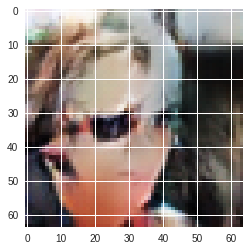

5/10, 72.72012578616352%
  G loss: 3.223051071166992
  D loss: 0.3602583408355713
5/10, 74.68553459119497%
  G loss: 2.221545457839966
  D loss: 0.4458577334880829
5/10, 76.65094339622641%
  G loss: 2.5145325660705566
  D loss: 0.3852362036705017
5/10, 78.61635220125787%
  G loss: 0.8875843286514282
  D loss: 0.8839575052261353


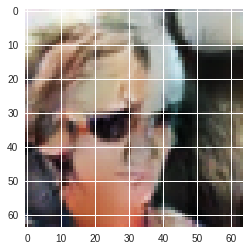

5/10, 80.58176100628931%
  G loss: 3.104264974594116
  D loss: 0.27710604667663574
5/10, 82.54716981132076%
  G loss: 2.7464778423309326
  D loss: 0.2849734425544739
5/10, 84.5125786163522%
  G loss: 2.893697738647461
  D loss: 0.32166194915771484
5/10, 86.47798742138365%
  G loss: 3.346379041671753
  D loss: 0.36586177349090576


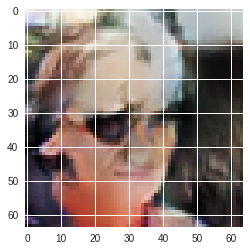

5/10, 88.44339622641509%
  G loss: 0.09467266499996185
  D loss: 1.0812370777130127
5/10, 90.40880503144653%
  G loss: 3.378386974334717
  D loss: 0.5026320815086365
5/10, 92.37421383647799%
  G loss: 2.6881797313690186
  D loss: 0.3093274235725403
5/10, 94.33962264150944%
  G loss: 4.232973098754883
  D loss: 0.4877519905567169


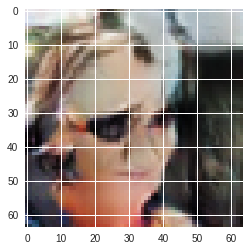

5/10, 96.30503144654088%
  G loss: 3.476245403289795
  D loss: 0.3223210871219635
5/10, 98.27044025157232%
  G loss: 4.767128944396973
  D loss: 0.4225432574748993
6/10, 0.0%
  G loss: 3.970888376235962
  D loss: 0.23973917961120605


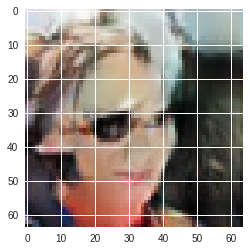

6/10, 1.9654088050314464%
  G loss: 3.0927071571350098
  D loss: 0.2095273733139038
6/10, 3.930817610062893%
  G loss: 3.398336887359619
  D loss: 0.3269011974334717
6/10, 5.89622641509434%
  G loss: 0.9771536588668823
  D loss: 0.6473219394683838
6/10, 7.861635220125786%
  G loss: 3.4619603157043457
  D loss: 0.20496387779712677


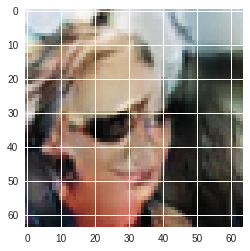

6/10, 9.827044025157234%
  G loss: 3.5412745475769043
  D loss: 0.3086671829223633
6/10, 11.79245283018868%
  G loss: 0.13674499094486237
  D loss: 2.870877981185913
6/10, 13.757861635220126%
  G loss: 6.016955375671387
  D loss: 0.8559926152229309
6/10, 15.723270440251572%
  G loss: 3.098461151123047
  D loss: 0.42948657274246216


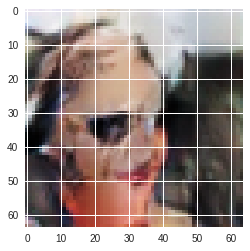

6/10, 17.68867924528302%
  G loss: 4.484671592712402
  D loss: 0.30840668082237244
6/10, 19.654088050314467%
  G loss: 5.263816833496094
  D loss: 0.4091807007789612
6/10, 21.61949685534591%
  G loss: 4.94180965423584
  D loss: 0.4475260376930237
6/10, 23.58490566037736%
  G loss: 2.8747568130493164
  D loss: 0.3341541886329651


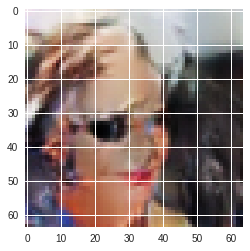

6/10, 25.550314465408807%
  G loss: 3.1664323806762695
  D loss: 0.6102306246757507
6/10, 27.51572327044025%
  G loss: 3.8757948875427246
  D loss: 0.2697734832763672
6/10, 29.4811320754717%
  G loss: 7.946761131286621
  D loss: 1.1985759735107422
6/10, 31.446540880503143%
  G loss: 1.6917189359664917
  D loss: 0.324597030878067


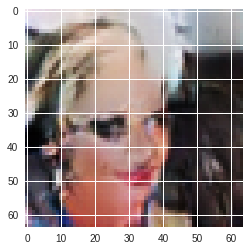

6/10, 33.411949685534594%
  G loss: 3.113077163696289
  D loss: 0.24564304947853088
6/10, 35.37735849056604%
  G loss: 3.314413547515869
  D loss: 0.4733453691005707
6/10, 37.34276729559748%
  G loss: 3.5635080337524414
  D loss: 0.21088510751724243
6/10, 39.308176100628934%
  G loss: 4.555912971496582
  D loss: 0.2919727861881256


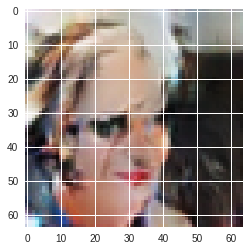

6/10, 41.27358490566038%
  G loss: 6.097599983215332
  D loss: 0.543303370475769
6/10, 43.23899371069182%
  G loss: 3.340360641479492
  D loss: 0.1943817138671875
6/10, 45.20440251572327%
  G loss: 4.608161926269531
  D loss: 0.38177910447120667
6/10, 47.16981132075472%
  G loss: 0.6179074048995972
  D loss: 1.1115771532058716


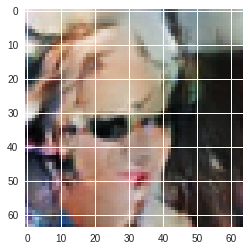

6/10, 49.13522012578616%
  G loss: 4.155279159545898
  D loss: 0.2541806697845459
6/10, 51.100628930817614%
  G loss: 2.549259662628174
  D loss: 0.25388604402542114
6/10, 53.06603773584906%
  G loss: 3.358168125152588
  D loss: 0.24723759293556213
6/10, 55.0314465408805%
  G loss: 3.128812789916992
  D loss: 0.2698175013065338


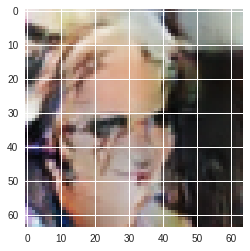

6/10, 56.996855345911946%
  G loss: 3.057190418243408
  D loss: 0.3683832883834839
6/10, 58.9622641509434%
  G loss: 2.1229562759399414
  D loss: 0.41818225383758545
6/10, 60.92767295597484%
  G loss: 4.627205848693848
  D loss: 0.24361145496368408
6/10, 62.893081761006286%
  G loss: 2.201362133026123
  D loss: 0.3584609031677246


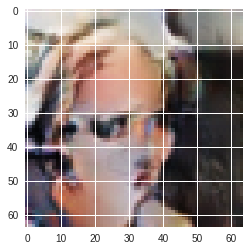

6/10, 64.85849056603774%
  G loss: 3.297280788421631
  D loss: 0.24589315056800842
6/10, 66.82389937106919%
  G loss: 4.206913948059082
  D loss: 0.2499101161956787
6/10, 68.78930817610063%
  G loss: 4.519306182861328
  D loss: 0.29788878560066223
6/10, 70.75471698113208%
  G loss: 3.3805484771728516
  D loss: 0.16220849752426147


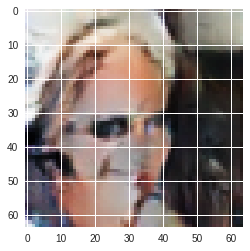

6/10, 72.72012578616352%
  G loss: 4.054224967956543
  D loss: 0.28032898902893066
6/10, 74.68553459119497%
  G loss: 4.577389240264893
  D loss: 0.17299668490886688
6/10, 76.65094339622641%
  G loss: 4.114500045776367
  D loss: 0.1812623143196106
6/10, 78.61635220125787%
  G loss: 4.0193071365356445
  D loss: 0.27227622270584106


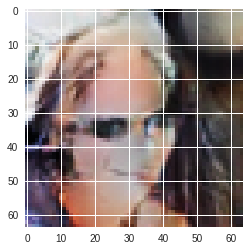

6/10, 80.58176100628931%
  G loss: 1.736823558807373
  D loss: 0.38678187131881714
6/10, 82.54716981132076%
  G loss: 5.401785373687744
  D loss: 0.21753568947315216
6/10, 84.5125786163522%
  G loss: 4.592709064483643
  D loss: 0.3521690368652344
6/10, 86.47798742138365%
  G loss: 3.481389045715332
  D loss: 0.21831528842449188


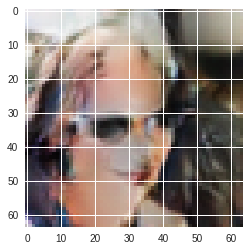

6/10, 88.44339622641509%
  G loss: 5.191658973693848
  D loss: 0.4337407648563385
6/10, 90.40880503144653%
  G loss: 2.640840768814087
  D loss: 0.2830926775932312
6/10, 92.37421383647799%
  G loss: 2.7651050090789795
  D loss: 0.39738529920578003
6/10, 94.33962264150944%
  G loss: 3.0210981369018555
  D loss: 0.22718770802021027


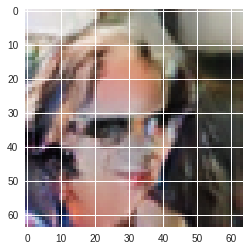

6/10, 96.30503144654088%
  G loss: 3.6394433975219727
  D loss: 0.41410595178604126
6/10, 98.27044025157232%
  G loss: 4.2740397453308105
  D loss: 0.15057863295078278
7/10, 0.0%
  G loss: 2.9523630142211914
  D loss: 0.2943081259727478


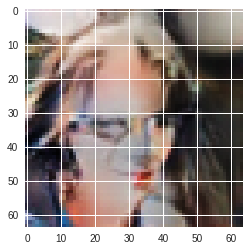

7/10, 1.9654088050314464%
  G loss: 2.6691362857818604
  D loss: 0.25211429595947266
7/10, 3.930817610062893%
  G loss: 4.668242454528809
  D loss: 0.3581939935684204
7/10, 5.89622641509434%
  G loss: 4.453122138977051
  D loss: 0.2229926586151123
7/10, 7.861635220125786%
  G loss: 3.0069947242736816
  D loss: 0.16869860887527466


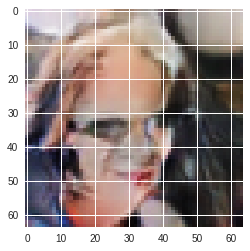

7/10, 9.827044025157234%
  G loss: 4.078771591186523
  D loss: 0.20573100447654724
7/10, 11.79245283018868%
  G loss: 4.360713005065918
  D loss: 0.2523043751716614
7/10, 13.757861635220126%
  G loss: 0.8434863090515137
  D loss: 0.6580026745796204
7/10, 15.723270440251572%
  G loss: 5.241175174713135
  D loss: 0.4762154817581177


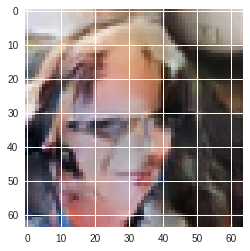

7/10, 17.68867924528302%
  G loss: 4.018570423126221
  D loss: 0.3211783468723297
7/10, 19.654088050314467%
  G loss: 4.027655601501465
  D loss: 0.14696574211120605
7/10, 21.61949685534591%
  G loss: 5.608590126037598
  D loss: 0.3114440441131592
7/10, 23.58490566037736%
  G loss: 4.119514465332031
  D loss: 0.2905224561691284


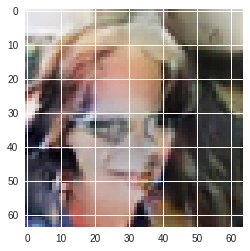

7/10, 25.550314465408807%
  G loss: 4.742270469665527
  D loss: 0.3402753472328186
7/10, 27.51572327044025%
  G loss: 3.936326026916504
  D loss: 0.42392581701278687
7/10, 29.4811320754717%
  G loss: 3.385007381439209
  D loss: 0.3359234929084778
7/10, 31.446540880503143%
  G loss: 3.2740745544433594
  D loss: 0.24400286376476288


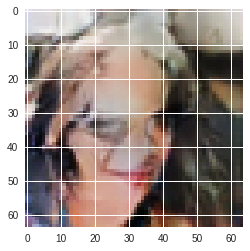

7/10, 33.411949685534594%
  G loss: 2.7739737033843994
  D loss: 0.24571259319782257
7/10, 35.37735849056604%
  G loss: 4.785634994506836
  D loss: 0.12785615026950836
7/10, 37.34276729559748%
  G loss: 3.0283360481262207
  D loss: 0.7218979001045227
7/10, 39.308176100628934%
  G loss: 4.244668483734131
  D loss: 0.22494417428970337


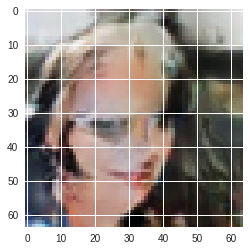

7/10, 41.27358490566038%
  G loss: 6.849987983703613
  D loss: 0.4924440085887909
7/10, 43.23899371069182%
  G loss: 1.8841660022735596
  D loss: 0.758118748664856
7/10, 45.20440251572327%
  G loss: 3.342266082763672
  D loss: 0.2328968048095703
7/10, 47.16981132075472%
  G loss: 2.7690117359161377
  D loss: 0.3274027705192566


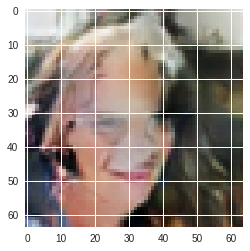

7/10, 49.13522012578616%
  G loss: 2.7560718059539795
  D loss: 0.2508195638656616
7/10, 51.100628930817614%
  G loss: 3.8322806358337402
  D loss: 0.20536281168460846
7/10, 53.06603773584906%
  G loss: 3.8696045875549316
  D loss: 0.21908006072044373
7/10, 55.0314465408805%
  G loss: 2.9576892852783203
  D loss: 0.39499518275260925


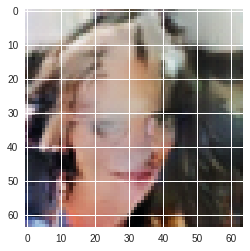

7/10, 56.996855345911946%
  G loss: 2.6480393409729004
  D loss: 0.20744553208351135
7/10, 58.9622641509434%
  G loss: 2.7011959552764893
  D loss: 0.6098155975341797
7/10, 60.92767295597484%
  G loss: 4.721332550048828
  D loss: 0.19194498658180237
7/10, 62.893081761006286%
  G loss: 3.989868640899658
  D loss: 0.32923921942710876


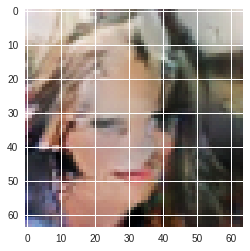

7/10, 64.85849056603774%
  G loss: 1.2907787561416626
  D loss: 1.1049236059188843
7/10, 66.82389937106919%
  G loss: 2.4475409984588623
  D loss: 0.38702887296676636
7/10, 68.78930817610063%
  G loss: 4.537851333618164
  D loss: 0.16145294904708862
7/10, 70.75471698113208%
  G loss: 3.13655161857605
  D loss: 0.2707555294036865


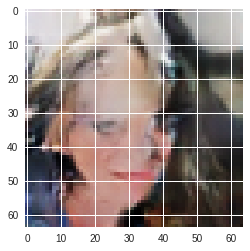

7/10, 72.72012578616352%
  G loss: 6.655844688415527
  D loss: 0.4341704249382019
7/10, 74.68553459119497%
  G loss: 0.661261260509491
  D loss: 0.8161634206771851
7/10, 76.65094339622641%
  G loss: 3.3404836654663086
  D loss: 0.28583478927612305
7/10, 78.61635220125787%
  G loss: 2.111025810241699
  D loss: 0.34313908219337463


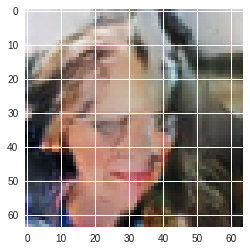

7/10, 80.58176100628931%
  G loss: 7.405761241912842
  D loss: 0.4591482877731323
7/10, 82.54716981132076%
  G loss: 6.4481306076049805
  D loss: 0.43982771039009094
7/10, 84.5125786163522%
  G loss: 4.168846130371094
  D loss: 0.7273916602134705
7/10, 86.47798742138365%
  G loss: 3.5066745281219482
  D loss: 0.22182141244411469


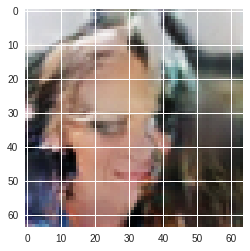

7/10, 88.44339622641509%
  G loss: 2.0038671493530273
  D loss: 0.4622093141078949
7/10, 90.40880503144653%
  G loss: 3.544581174850464
  D loss: 0.4568215608596802
7/10, 92.37421383647799%
  G loss: 2.698338031768799
  D loss: 0.318412184715271
7/10, 94.33962264150944%
  G loss: 4.487944602966309
  D loss: 0.14005309343338013


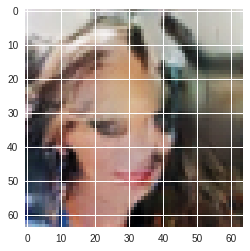

7/10, 96.30503144654088%
  G loss: 2.965200424194336
  D loss: 0.2326982319355011
7/10, 98.27044025157232%
  G loss: 4.106809139251709
  D loss: 0.2045544683933258
8/10, 0.0%
  G loss: 3.9646973609924316
  D loss: 0.17407208681106567


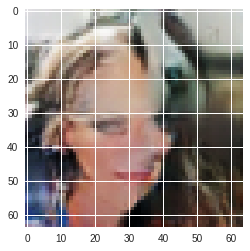

8/10, 1.9654088050314464%
  G loss: 11.508563995361328
  D loss: 1.8795645236968994
8/10, 3.930817610062893%
  G loss: 3.165816307067871
  D loss: 0.35604584217071533
8/10, 5.89622641509434%
  G loss: 4.4403181076049805
  D loss: 0.1477300226688385
8/10, 7.861635220125786%
  G loss: 4.342432975769043
  D loss: 0.2609633505344391


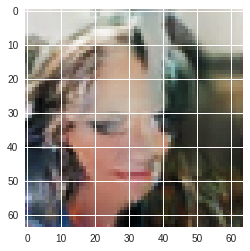

8/10, 9.827044025157234%
  G loss: 2.3013687133789062
  D loss: 0.2975143492221832
8/10, 11.79245283018868%
  G loss: 4.565087795257568
  D loss: 0.29998674988746643
8/10, 13.757861635220126%
  G loss: 3.9462757110595703
  D loss: 0.24924811720848083
8/10, 15.723270440251572%
  G loss: 7.686222076416016
  D loss: 3.354278564453125


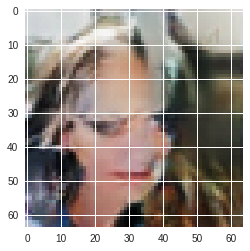

8/10, 17.68867924528302%
  G loss: 2.4579524993896484
  D loss: 0.341711163520813
8/10, 19.654088050314467%
  G loss: 3.8176181316375732
  D loss: 0.17811210453510284
8/10, 21.61949685534591%
  G loss: 3.733407974243164
  D loss: 0.1430814564228058
8/10, 23.58490566037736%
  G loss: 2.8439018726348877
  D loss: 0.19142456352710724


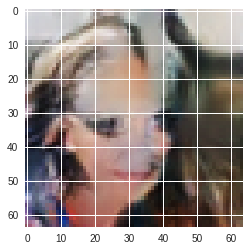

8/10, 25.550314465408807%
  G loss: 3.5925655364990234
  D loss: 0.36917048692703247
8/10, 27.51572327044025%
  G loss: 4.034616470336914
  D loss: 0.2691315710544586
8/10, 29.4811320754717%
  G loss: 3.901109218597412
  D loss: 0.14692530035972595
8/10, 31.446540880503143%
  G loss: 4.623039722442627
  D loss: 0.26262760162353516


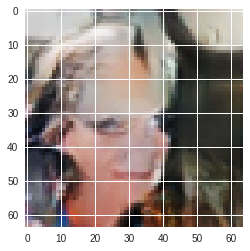

8/10, 33.411949685534594%
  G loss: 3.2939107418060303
  D loss: 0.3255763053894043
8/10, 35.37735849056604%
  G loss: 5.275585174560547
  D loss: 0.30110421776771545
8/10, 37.34276729559748%
  G loss: 4.131258010864258
  D loss: 0.13016733527183533
8/10, 39.308176100628934%
  G loss: 9.737907409667969
  D loss: 3.7074551582336426


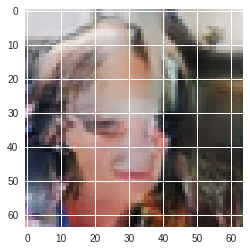

8/10, 41.27358490566038%
  G loss: 5.285252094268799
  D loss: 0.5104243755340576
8/10, 43.23899371069182%
  G loss: 3.250399351119995
  D loss: 0.25641536712646484
8/10, 45.20440251572327%
  G loss: 4.011288642883301
  D loss: 0.26051217317581177
8/10, 47.16981132075472%
  G loss: 4.829388618469238
  D loss: 0.2234792709350586


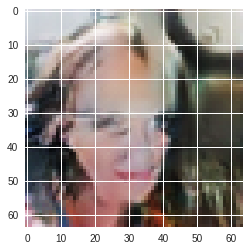

8/10, 49.13522012578616%
  G loss: 2.248574733734131
  D loss: 0.823915421962738
8/10, 51.100628930817614%
  G loss: 5.402267932891846
  D loss: 0.28606173396110535
8/10, 53.06603773584906%
  G loss: 3.993128538131714
  D loss: 0.27771642804145813
8/10, 55.0314465408805%
  G loss: 3.66353702545166
  D loss: 0.20222069323062897


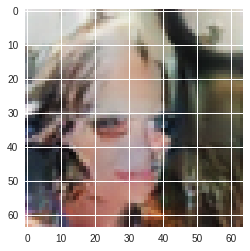

8/10, 56.996855345911946%
  G loss: 3.683917999267578
  D loss: 0.16688236594200134
8/10, 58.9622641509434%
  G loss: 3.893178701400757
  D loss: 0.15436071157455444
8/10, 60.92767295597484%
  G loss: 4.1159234046936035
  D loss: 0.13146451115608215
8/10, 62.893081761006286%
  G loss: 1.3520816564559937
  D loss: 0.7580528855323792


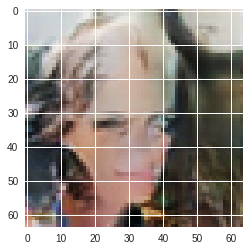

8/10, 64.85849056603774%
  G loss: 3.9648706912994385
  D loss: 0.4969859719276428
8/10, 66.82389937106919%
  G loss: 3.449570655822754
  D loss: 0.28479504585266113
8/10, 68.78930817610063%
  G loss: 4.009024143218994
  D loss: 0.29696139693260193
8/10, 70.75471698113208%
  G loss: 4.248745918273926
  D loss: 0.17742206156253815


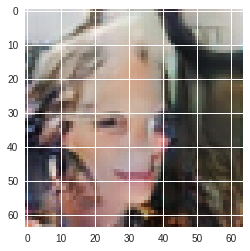

8/10, 72.72012578616352%
  G loss: 3.625847816467285
  D loss: 0.20679451525211334
8/10, 74.68553459119497%
  G loss: 0.956821620464325
  D loss: 6.077754020690918
8/10, 76.65094339622641%
  G loss: 7.282650947570801
  D loss: 0.7002440094947815
8/10, 78.61635220125787%
  G loss: 5.42974853515625
  D loss: 0.2605648338794708


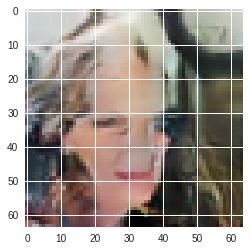

8/10, 80.58176100628931%
  G loss: 4.232844352722168
  D loss: 0.223300039768219
8/10, 82.54716981132076%
  G loss: 5.250509262084961
  D loss: 0.3397233486175537
8/10, 84.5125786163522%
  G loss: 4.837368011474609
  D loss: 0.5040087699890137
8/10, 86.47798742138365%
  G loss: 2.339925765991211
  D loss: 0.3437795341014862


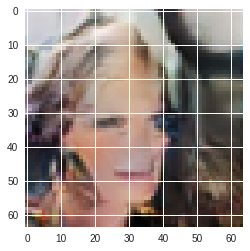

8/10, 88.44339622641509%
  G loss: 4.800568580627441
  D loss: 0.18455925583839417
8/10, 90.40880503144653%
  G loss: 3.677844524383545
  D loss: 0.177382230758667
8/10, 92.37421383647799%
  G loss: 4.853548049926758
  D loss: 0.12945091724395752
8/10, 94.33962264150944%
  G loss: 3.5194406509399414
  D loss: 0.17489343881607056


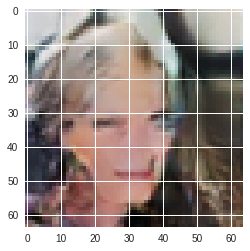

8/10, 96.30503144654088%
  G loss: 0.3668995201587677
  D loss: 1.378900170326233
8/10, 98.27044025157232%
  G loss: 6.175172805786133
  D loss: 0.5186102390289307
9/10, 0.0%
  G loss: 3.027078151702881
  D loss: 0.27911049127578735


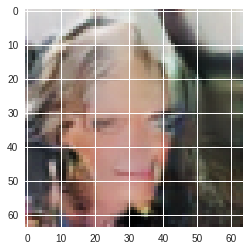

9/10, 1.9654088050314464%
  G loss: 3.0828983783721924
  D loss: 0.2078486531972885
9/10, 3.930817610062893%
  G loss: 3.2649803161621094
  D loss: 0.23422911763191223
9/10, 5.89622641509434%
  G loss: 3.957120418548584
  D loss: 0.11409346014261246
9/10, 7.861635220125786%
  G loss: 4.9103217124938965
  D loss: 0.19689619541168213


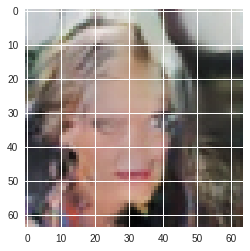

9/10, 9.827044025157234%
  G loss: 4.178125381469727
  D loss: 0.17316049337387085
9/10, 11.79245283018868%
  G loss: 5.031876087188721
  D loss: 0.19446241855621338
9/10, 13.757861635220126%
  G loss: 1.0470623970031738
  D loss: 2.2334680557250977
9/10, 15.723270440251572%
  G loss: 2.8897199630737305
  D loss: 0.47141724824905396


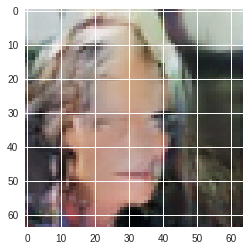

9/10, 17.68867924528302%
  G loss: 4.599371910095215
  D loss: 0.2291041910648346
9/10, 19.654088050314467%
  G loss: 5.620815753936768
  D loss: 0.17393693327903748
9/10, 21.61949685534591%
  G loss: 4.827221870422363
  D loss: 0.08844907581806183
9/10, 23.58490566037736%
  G loss: 2.78987717628479
  D loss: 0.25149112939834595


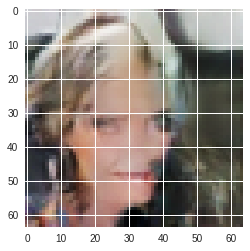

9/10, 25.550314465408807%
  G loss: 10.301517486572266
  D loss: 6.075197219848633
9/10, 27.51572327044025%
  G loss: 3.262971878051758
  D loss: 0.5092461109161377
9/10, 29.4811320754717%
  G loss: 3.2103657722473145
  D loss: 0.33586952090263367
9/10, 31.446540880503143%
  G loss: 3.5524230003356934
  D loss: 0.69046950340271


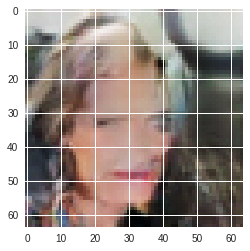

9/10, 33.411949685534594%
  G loss: 4.418098449707031
  D loss: 0.1744801104068756
9/10, 35.37735849056604%
  G loss: 8.921935081481934
  D loss: 0.7409399151802063
9/10, 37.34276729559748%
  G loss: 2.66674542427063
  D loss: 0.41365957260131836
9/10, 39.308176100628934%
  G loss: 3.988316297531128
  D loss: 0.11775873601436615


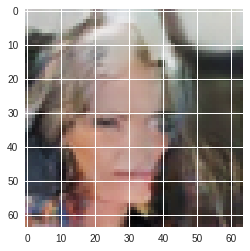

9/10, 41.27358490566038%
  G loss: 5.153851509094238
  D loss: 0.346912682056427
9/10, 43.23899371069182%
  G loss: 4.019009113311768
  D loss: 0.2743750810623169
9/10, 45.20440251572327%
  G loss: 5.700553894042969
  D loss: 0.3593687415122986
9/10, 47.16981132075472%
  G loss: 8.139644622802734
  D loss: 0.7244853377342224


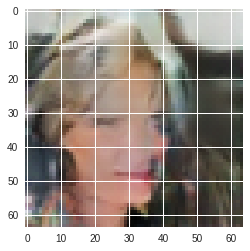

9/10, 49.13522012578616%
  G loss: 5.077106952667236
  D loss: 0.18572667241096497
9/10, 51.100628930817614%
  G loss: 4.289965629577637
  D loss: 0.13202588260173798
9/10, 53.06603773584906%
  G loss: 2.0690603256225586
  D loss: 0.3174428939819336
9/10, 55.0314465408805%
  G loss: 2.739558219909668
  D loss: 0.5241497755050659


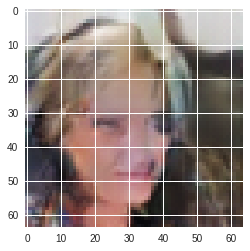

9/10, 56.996855345911946%
  G loss: 6.49766731262207
  D loss: 0.5525188446044922
9/10, 58.9622641509434%
  G loss: 1.001206398010254
  D loss: 1.6722997426986694
9/10, 60.92767295597484%
  G loss: 4.394991874694824
  D loss: 0.11597482860088348
9/10, 62.893081761006286%
  G loss: 3.848217487335205
  D loss: 0.12182438373565674


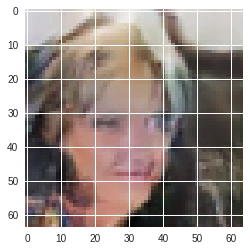

9/10, 64.85849056603774%
  G loss: 2.682638168334961
  D loss: 0.24098807573318481
9/10, 66.82389937106919%
  G loss: 5.129897117614746
  D loss: 0.35311567783355713
9/10, 68.78930817610063%
  G loss: 3.4848477840423584
  D loss: 0.26119160652160645
9/10, 70.75471698113208%
  G loss: 4.673384666442871
  D loss: 0.09644626826047897


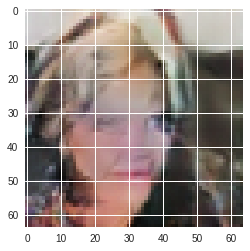

9/10, 72.72012578616352%
  G loss: 4.496304512023926
  D loss: 0.17684029042720795
9/10, 74.68553459119497%
  G loss: 6.106990814208984
  D loss: 0.2792089581489563
9/10, 76.65094339622641%
  G loss: 2.980252742767334
  D loss: 0.31109240651130676
9/10, 78.61635220125787%
  G loss: 3.859539031982422
  D loss: 0.15207716822624207


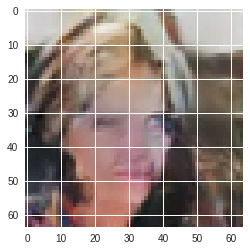

9/10, 80.58176100628931%
  G loss: 4.422570705413818
  D loss: 0.24809530377388
9/10, 82.54716981132076%
  G loss: 4.366681098937988
  D loss: 0.07884862273931503
9/10, 84.5125786163522%
  G loss: 2.364121913909912
  D loss: 1.4182536602020264
9/10, 86.47798742138365%
  G loss: 3.602525472640991
  D loss: 0.2016894370317459


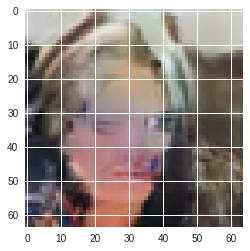

9/10, 88.44339622641509%
  G loss: 3.9453659057617188
  D loss: 0.08027052879333496
9/10, 90.40880503144653%
  G loss: 2.860672950744629
  D loss: 0.8139057755470276
9/10, 92.37421383647799%
  G loss: 4.190301895141602
  D loss: 0.17965489625930786
9/10, 94.33962264150944%
  G loss: 5.536192893981934
  D loss: 0.9598993062973022


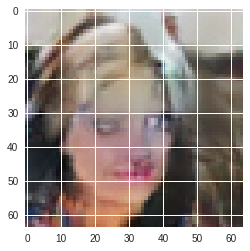

9/10, 96.30503144654088%
  G loss: 4.365803241729736
  D loss: 0.3156207799911499
9/10, 98.27044025157232%
  G loss: 3.6487884521484375
  D loss: 0.11114662140607834


In [58]:
ii = 0
fixed_noise=torch.randn(1, latent_size, 1, 1).to(device)
num_epochs = 10
optim_D = optim.Adam(D.parameters(), lr=learning_rate,betas=(0.5, 0.999))
optim_G = optim.Adam(G.parameters(), lr=learning_rate,betas=(0.5, 0.999))
criterion = nn.BCELoss().to(device)


for epoch in range(num_epochs):
  iters = 0
    
  G_ls = []
  D_ls = []
  for data, _ in loader:
    
    y_real = data.to(device)
    #print(y_real.size())
    b_s = y_real.size(0)
    #print(b_s)
    if b_s != 64:
      continue
      
    D.zero_grad()
    lbl = torch.full((b_s,), 1, device = device)
    #print(lbl)
    out = D(y_real).squeeze()
    lD_real = criterion(out, lbl)
    lD_real.backward()
    
    
    zz = torch.randn(batch_size, latent_size, 1, 1, device=device)
    y_fake = G(zz)
    lbl.fill_(0)
    out = D(y_fake.detach()).squeeze()
    lD_fake = criterion(out, lbl)
    lD_fake.backward()
    lD = lD_real + lD_fake
    optim_D.step()
    
    
    
    G.zero_grad()
    lbl.fill_(1)
    out = D(y_fake).squeeze()
    lG = criterion(out, lbl)
    lG.backward()
    optim_G.step()

    if iters % 50 == 0:
            # Выведем информацию о том, как наша сеть справляется
      print(f'{epoch}/{num_epochs}, {iters/len(loader)*100}%')
      print(f'  G loss: {lG.item()}')
      print(f'  D loss: {lD.item()}')

    if iters % 200 == 0:
            fake = G(fixed_noise).squeeze()
        
            plt.imshow((fake.cpu().data.numpy().transpose(1, 2, 0)+1)/2)
            plt.show()
    iters += 1


    

In [0]:
from google.colab import files
torch.save(D, 'D.pt')
files.download('D.pt')

torch.save(G, 'G.pt')
files.download('G.pt')

In [0]:
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

In [0]:
img_pred = to_numpy_image(img_list[0])
    # теперь это numpy-евский ndarray размера (128, 128, 3)
plt.figure(figsize=(10,10))
plt.imshow(img_pred)

In [0]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
# распечатайте ваши картинки

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.